# Numerically solving Laplace's equation

# The first large chunk of this notebook is review. Then comes some new thinking about convergence, boundary conditions, etc.

## Set up and solve once

We discussed in class the idea that the Laplacian, $\nabla^2$, is often referred to as "the averaging operator."[1] We'll put that idea into practice to solve Laplace's equation numerically. We'll do this to solve Laplace's equation ($\nabla^2u=0$) in 2D. We'll do a few things in the code, but the heart of the idea is that we'll divide our system up into a grid, specify the temperature on the boundaries, and then iteratively set each internal point to the average of the surrounding points.

I'll use `imshow` in the main code, but [ipython blocks](https://github.com/jiffyclub/ipythonblocks) makes for nice pretty pictures as a setup.

[1]There are two quick ways to see this. The first is to take the limit definition of the 2nd derivative (noting that you're specifically applying it to functions where limits commute). The second is to take a Taylor expansions and add them together.

In [1]:
%matplotlib notebook
from ipythonblocks import BlockGrid
import numpy as np, matplotlib.pyplot as plt

Let's start with a 20x20 grid

In [2]:
grid = BlockGrid(20,20)
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


And set the boundary conditions. In particular, let's say the left edge is set at 200, and the other edges are set at 0. We'll let temperature be represented by the "red" part of an RGB value. That means we can set `block.red` to any number between `0` and `255`.

We'll start with the whole grid at 0 except for the boundary in question.

In [3]:
for block in grid:
    if block.col == 0:
        block.red = 200
    else:
        block.red = 0
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


Now, for each round of updating (think of passing the pie in class), we want to iterate over all of the internal blocks, setting their red value equal to the average of their neighbors. By "neighbor," let's say we mean the 4 blocks immediately above, below, left and right.

Our boundary conditions are pretty easy to enforce: if we're in the left or right column (numbered 0 and 19, because Python starts counting from zero), or in the top or bottom row (again, numbered 0 and 19), don't do a thing.

In [4]:
for block in grid:
    if block.col in (0,19) or block.row in (0,19):
        continue
    block.red = (grid[block.row-1,block.col].red + grid[block.row+1,block.col].red +\
                 grid[block.row,block.col-1].red + grid[block.row,block.col+1].red) / 4.0
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [5]:
grid.lines_on = False
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


If you look closely, you can indeed see that the second row has some red in it. Remember, this is an approximation method. That means we need to run it over and over until it converges. We'll worry about convergence later; for now, let's wrap it up in a function and run it 10 times:

In [6]:
def one_step():
    for block in grid:
        if block.col in (0,19) or block.row in (0,19):
            continue
        block.red = (grid[block.row-1,block.col].red + grid[block.row+1,block.col].red +\
                     grid[block.row,block.col-1].red + grid[block.row,block.col+1].red) / 4.0
for i in range(10):
    one_step()
grid.lines_on = False
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


We can eyeball our results to see if they've converged by just running it longer:

In [7]:
for i in range(500):
    one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


And that's really all we need to do to solve Laplace's equation numerically. 

## Different boundary conditions
Wonder what it looks like with the top and bottom sides set to 200 instead? Just change the boundary conditions and run it again:

In [8]:
for block in grid:
    if block.row in (0,19):
        block.red = 200
    else:
        block.red = 0
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [9]:
for i in range(1):
    one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


## Initial conditions

We know from class that, while the boundary conditions matter, the initial state shouldn't matter at all; the steady-state solution doesn't care. Let's see that by initializing to *random* values from 0 to 255. This is done with np.random.randint(0,256):

In [10]:
for block in grid:
    if block.row in (0,19):
        block.red = 200
    elif block.col in (0,19):
        block.red = 0
    else:
        block.red = np.random.randint(0,200)
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


It's interesting to watch one or two steps explicitly to see that it's doing what we expect, then to run things for a while.

In [11]:
one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [12]:
one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [13]:
one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


Seems to be working ...

In [14]:
for i in range(500):
    one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


And, as promised, it looks like we're converging to the same solution. This sort of thing makes it easy to plug in different boundary conditions and examine the result. We can try all sorts of strange things. Here's an example:

In [15]:
for block in grid:
    if block.row == 0:
        block.red = block.col * 10
    elif block.row == 19:
        block.red = (19 - block.col) * 10
    elif block.col in (0,19):
        if divmod(block.row,2)[1] == 0:
            block.red = 200
        else:
            block.red = 0
    else:
        block.red = 0
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [16]:
one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [17]:
one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


In [18]:
for i in range(500):
    one_step()
grid

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


Not bad! One simple function (`one_step`) allowed us to solve all sorts of setups that would have been quite tough to handle analytically! The disadvantage is that we're approximating things, so we care about how many blocks we've divvied our grid up into, etc. If we want to handle more complicated systems, we'll have to switch to `numpy` and `imshow` instead of `ipythonblocks`.

## Switching to numpy and matplotlib and imshow

Here, `T` will be a `numpy` array describing our temperature.

For fun, we'll make the left boundary 100, but the right boundary part of a `sin` function. The `interpolation='none'` part of `imshow` tells it to show each member of the array like a square. Telling it something else like `interpolation='nearest'` or `'gaussian'` will smooth the picture out. That looks better, but it's a little harder to see exactly what's going on with our algorithm.

Note here that the default colormap for `imshow` has red as hot and blue as cold. Before, we were using black as cold. Here, we get more colors.

<IPython.core.display.Javascript object>


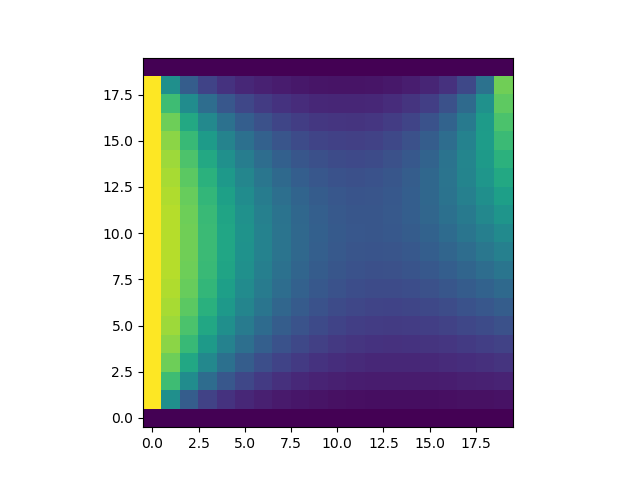

In [21]:
nx, ny = 20,20
T = np.zeros((nx,ny))
T[:,0] = 100 # Left boundary
T[:,-1] = 100*np.sin(np.arange(0,nx)/nx) # Right boundary
T[0,:] = 0 # Top boundary
T[-1,:] = 0 # Bottom boundary
plt.imshow(T,interpolation='none',origin='lower')

How will we know that we're done? We'll calculate how much the error changed between iterations. We'll do this by saving the previous step in `TN` and subtracting. We'll say that we've converged when the maximum error is lower than some threshold `epsilon`. We don't want to run forever, so we'll set a maximum number of iterations.

In [22]:
# We modify T in place. If you hate side effects, 
# make a copy of T at the beginning, 
# and change the return statements to return T
def solveLaplace(T,epsilon=1e-1,maxiter=1000):
    TN = T.copy()
    for i in range(maxiter):
        # We'll be a bit clever with numpy indexing here
        T[1:-1,1:-1] = (T[0:-2,1:-1]+T[2:,1:-1]+T[1:-1,0:-2]+T[1:-1,2:])/4.
        err = np.abs(TN - T)
        
        if np.max(err) < epsilon:
            print ("Reached convergence after",i+1,"iterations")
            print ("(max error: %g)"%(np.max(err)))
            return
        TN = T.copy()
    print ("No convergence after",i+1,"iterations")
    print ("(max error: %g)"%(np.max(err)))
    return

Reached convergence after 1 iterations
(max error: 0.0959819)


<IPython.core.display.Javascript object>


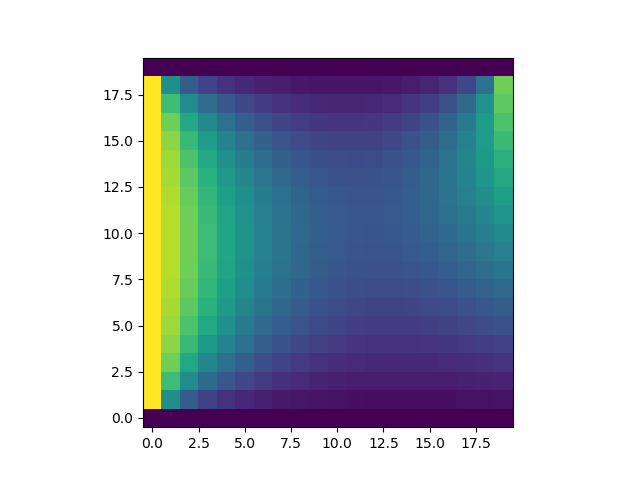

In [25]:
solveLaplace(T,maxiter=1000)
fig  = plt.figure()
plt.imshow(T,interpolation='None',origin='lower')

# START HERE for new stuff

In [26]:
%matplotlib notebook
from ipythonblocks import BlockGrid
import numpy as np, matplotlib.pyplot as plt

## What if we want to use some different boundary conditions?

Well, maybe we should wrap the boundary conditions up in "apply_boundary" and then we can run things iteratively, applying the boundary conditions after each averaging.

In [27]:
def apply_boundary(T,nx,ny):
    T[:,0] = 100 # Left boundary
    T[:,-1] = 100*np.sin(np.arange(0,nx)/nx) # Right boundary
    T[0,:] = 0 # Top boundary
    T[-1,:] = 0 # Bottom boundary
    
    
# We modify T in place. If you hate side effects, 
# make a copy of T at the beginning, 
# and change the return statements to return T
def solveLaplace(T,nx,ny,epsilon=1e-1,maxiter=1000):
    apply_boundary(T,nx,ny)
    TN = T.copy()
    for i in range(maxiter):
        # We'll be a bit clever with numpy indexing here
        T[1:-1,1:-1] = (T[0:-2,1:-1]+T[2:,1:-1]+T[1:-1,0:-2]+T[1:-1,2:])/4.
        apply_boundary(T,nx,ny)
        err = np.abs(TN - T)
        
        if np.max(err) < epsilon:
            print ("Reached convergence after",i+1,"iterations")
            print ("(max error: %g)"%(np.max(err)))
            return
        TN = T.copy()
    print ("No convergence after",i+1,"iterations")
    print ("(max error: %g)"%(np.max(err)))
    return

def plot_and_solve(nx=20,ny=20):
    T = np.zeros((nx,ny))

    
    fig = plt.figure()
    plt.imshow(T,interpolation='none',origin='lower')
    apply_boundary(T,nx,ny)
    fig = plt.figure()
    plt.imshow(T,interpolation='none',origin='lower')
    fig = plt.figure()
    solveLaplace(T,maxiter=1000,nx=nx,ny=ny)
    plt.imshow(T,interpolation='None',origin='lower')


### So, the above plots our initial conditions, the boundary as it's applied, then the converged solution

<IPython.core.display.Javascript object>


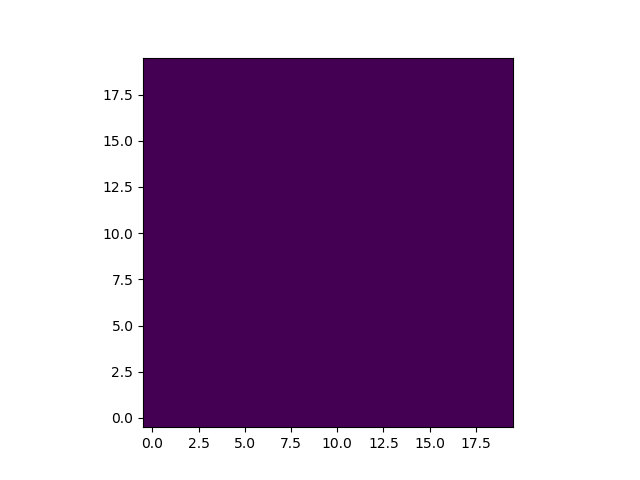

<IPython.core.display.Javascript object>


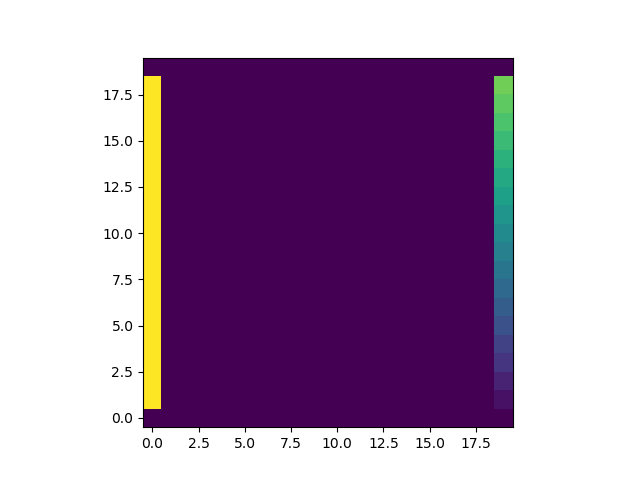

<IPython.core.display.Javascript object>


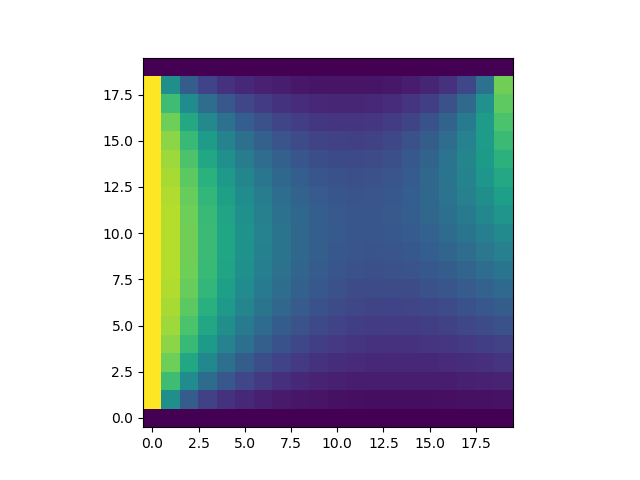

Reached convergence after 153 iterations
(max error: 0.0986651)


In [28]:
plot_and_solve()

Now, with different boundary conditions

<IPython.core.display.Javascript object>


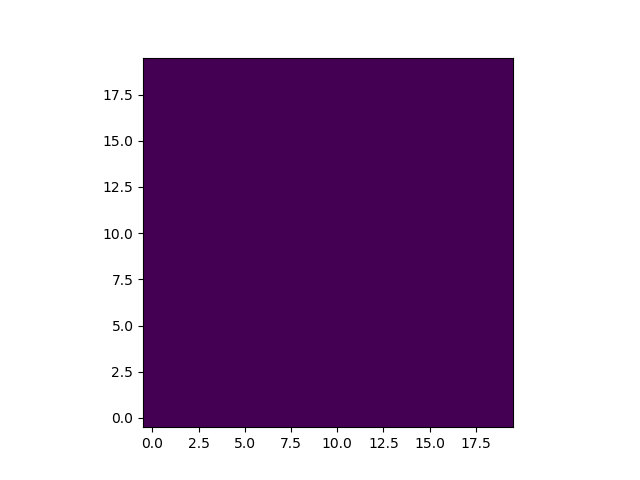

<IPython.core.display.Javascript object>


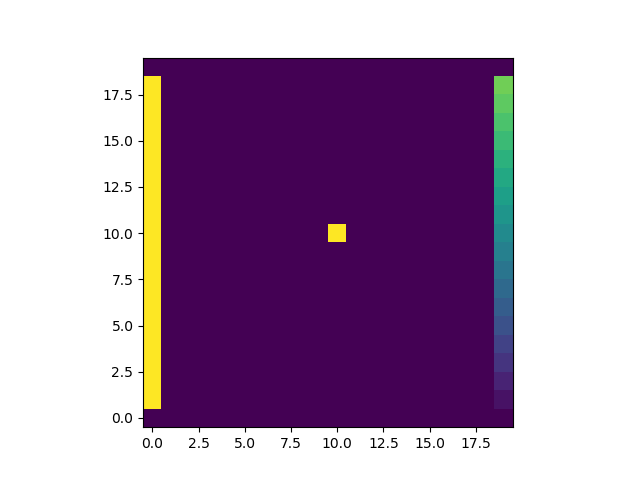

<IPython.core.display.Javascript object>


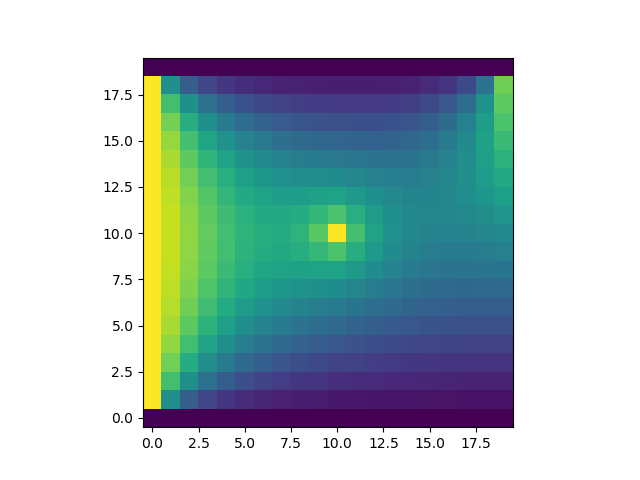

Reached convergence after 153 iterations
(max error: 0.0986531)


In [29]:
def apply_boundary(T,nx,ny):
    T[:,0] = 100 # Left boundary
    T[:,-1] = 100*np.sin(np.arange(0,nx)/nx) # Right boundary
    T[0,:] = 0 # Top boundary
    T[-1,:] = 0 # Bottom boundary
    T[10,10]=100
plot_and_solve()

<IPython.core.display.Javascript object>


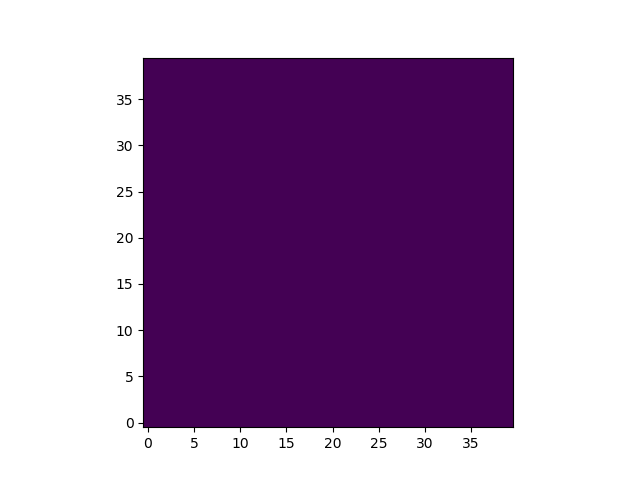

<IPython.core.display.Javascript object>


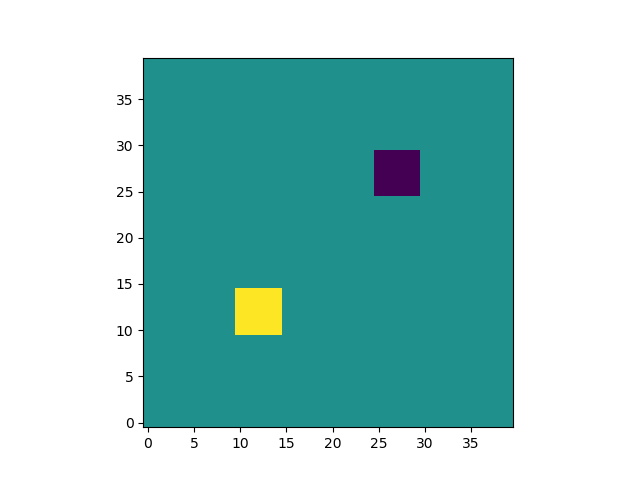

<IPython.core.display.Javascript object>


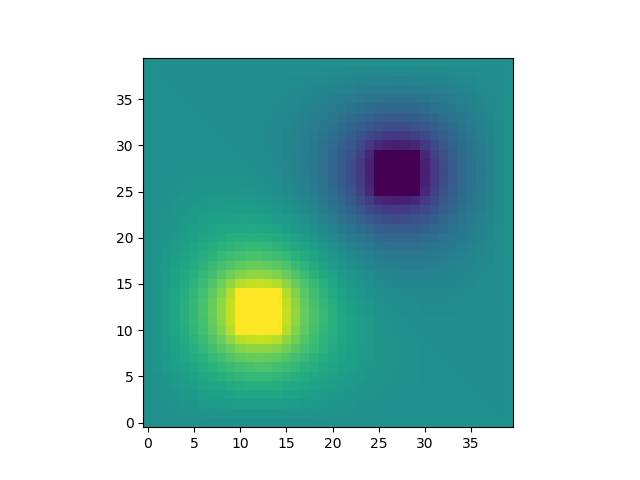

Reached convergence after 126 iterations
(max error: 0.0988158)


In [30]:
def apply_boundary(T,nx,ny):
    T[10:15,10:15]=100
    T[25:30,25:30]=-100
plot_and_solve(40,40)

## Animating it

We can make some fun animations matplotlib:

In [ ]:
#%%capture
from matplotlib import animation
#plt.rc('animation', html='html5')

data = np.random.random(20)
fig = plt.figure()

ax = fig.add_subplot(111)   
ax.plot(data) # draw background

anim = animation.ArtistAnimation(fig, [[ax.scatter(x, y)] for x, y in enumerate(data)])

In [ ]:
anim

Here, we're just going to chunk through a given number of frames and show the result. So, we'll get rid of the convergence testing. As with my last notebook, we'll use a "fragile" version, where we completely ignore the fact that the animator asks us to return results for a given value; instead, we'll just update T each time, ignoring that argument.

This time, the "fragile" business means we have to specifically not do anything the 1st time through, so that our first frame is the initial conditions.

In [ ]:
#%%capture
nx,ny = 20,20


fig = plt.figure()
ax = plt.gca()
T = np.zeros((nx,ny))
T[-1,:] = 0 # Bottom boundary


T[:,0] = 100 # Left boundary
T[:,-1] = 100*np.sin(np.arange(0,nx)/nx) # Right boundary
T[0,:] = 0 # Top boundary

def init():
    img = ax.imshow(T,interpolation='None')
    return img,
def updateLaplace_fragile(i):
    # Don't do anything the 1st time through, so that we plot the initial conditions
    if i != 0:
        T[1:-1,1:-1] = (T[0:-2,1:-1]+T[2:,1:-1]+T[1:-1,0:-2]+T[1:-1,2:])/4.
    img = ax.imshow(T,interpolation='None')
    return img,
ani = animation.FuncAnimation(fig, updateLaplace_fragile, init_func=init,
                        frames=150, blit=True)

In [ ]:
ani

So that's pretty neat. We can also try it out with random starting values

In [ ]:
ani

In [ ]:
#%%capture
fig = plt.figure()
ax = plt.gca()
T = np.random.rand(nx,ny)*100
T[:,0] = 100 # Left boundary
T[:,-1] = 100*np.sin(np.arange(0,nx)/nx) # Right boundary
T[0,:] = 0 # Top boundary
T[-1,:] = 0 # Bottom boundary
ani = animation.FuncAnimation(fig, updateLaplace_fragile, init_func=init,
                        frames=150, blit=True)

In [ ]:
ani

Which brings up an interesting point that you may have noticed if you played around with the random values in the `ipythonblocks` portion above: this can converge faster. Random initial conditions can actually be closer to our final value than setting everything equal to zero.

We can also try less random initial conditions

In [ ]:
#%%capture
import matplotlib.image as mpimg
import urllib
fig = plt.figure()
ax = plt.gca()
im = mpimg.imread(urllib.request.urlopen('http://mglerner.com/img/mgl_personal_small.png'))
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
T = rgb2gray(im)*100
nx,ny = T.shape
T[:,0] = 100 # Left boundary
T[:,-1] = 100*np.sin(4*np.arange(0,nx)/nx) # Right boundary
T[0,:] = 0 # Top boundary
T[-1,:] = 0 # Bottom boundary
ani = animation.FuncAnimation(fig, updateLaplace_fragile, init_func=init,
                        frames=500, blit=True)


In [ ]:
ani